# NLP project

I'm about to start my second NLP task and I'm trying out a faster and shorter NLP method this time around. However, the dataset I'm working with only has two sentiment values - positive and negative - which won't work with my model. So, I've decided to add a start and stop token to the dataset to make it fit better. This should improve the accuracy of my model and allow for more detailed analysis of the data.

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import Model
from keras.utils import pad_sequences

# Read in the dataset
data = pd.read_csv("IMDB Dataset.csv")

data.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Adding a start and stop token.

In [2]:
# Define the start and stop tokens
start_token = '<START>'
stop_token = '<STOP>'

# Add start and stop tokens to the sentiment column
data['sentiment'] = data['sentiment'].apply(lambda x: start_token + ' ' + x + ' ' + stop_token)
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,<START> positive <STOP>
1,A wonderful little production. <br /><br />The...,<START> positive <STOP>
2,I thought this was a wonderful way to spend ti...,<START> positive <STOP>
3,Basically there's a family where a little boy ...,<START> negative <STOP>
4,"Petter Mattei's ""Love in the Time of Money"" is...",<START> positive <STOP>
...,...,...
49995,I thought this movie did a down right good job...,<START> positive <STOP>
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",<START> negative <STOP>
49997,I am a Catholic taught in parochial elementary...,<START> negative <STOP>
49998,I'm going to have to disagree with the previou...,<START> negative <STOP>


## Data Cleaning

In order to improve the outcome of our analysis, we need to remove any punctuation and website URLs that may be present in the review data column. This is because such extraneous elements can interfere with the accuracy of our NLP model and produce less reliable results. Therefore, it is important to preprocess the data by removing any unnecessary elements before conducting any analysis or modeling.

### Visualizing the data

In [3]:
good_reviews=data[data['sentiment']=='<START> positive <STOP>']['review']
bad_reviews=data[data['sentiment']=='<START> negative <STOP>']['review']
print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])

First 10 samples of good reviews
 0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
4     Petter Mattei's "Love in the Time of Money" is...
5     Probably my all-time favorite movie, a story o...
6     I sure would like to see a resurrection of a u...
9     If you like original gut wrenching laughter yo...
14    This a fantastic movie of three prisoners who ...
16    Some films just simply should not be remade. T...
18    I remember this film,it was the first film i h...
Name: review, dtype: object
First 10 samples of bad reviews
 3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
12    So im not a big fan of Boll's work but then ag...
13    The

Total Counts of both sets <START> positive <STOP>    25000
<START> negative <STOP>    25000
Name: sentiment, dtype: int64


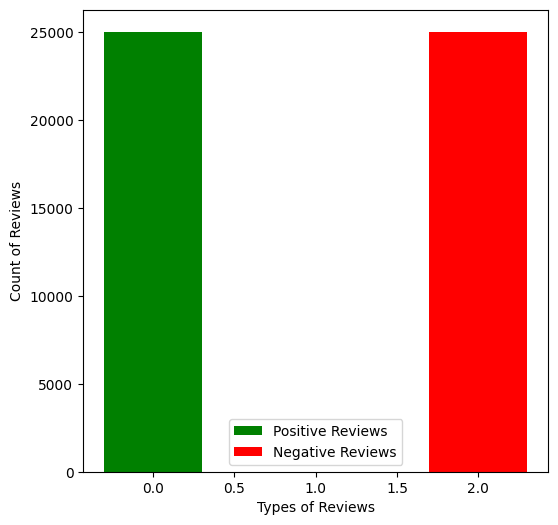

In [4]:
import matplotlib.pyplot as plt

#Count of good and bad reviews
count=data['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()
    
count_good=data[data['sentiment']=='<START> positive <STOP>']
count_bad=data[data['sentiment']=='<START> negative <STOP>']
plot_counts(len(count_good),len(count_bad))

<Axes: >

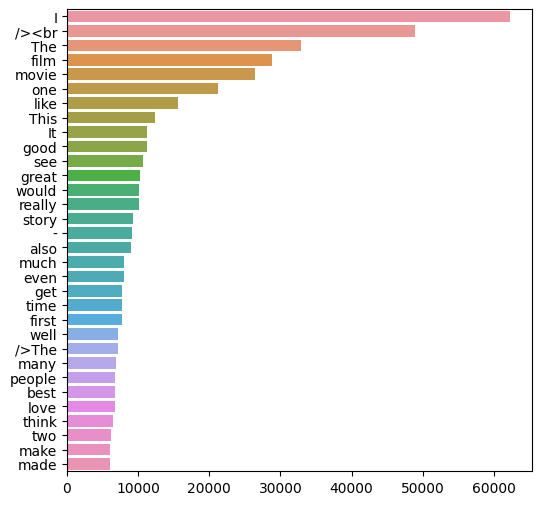

In [5]:
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stops=set(stopwords.words('english'))

#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in data[data['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus('<START> positive <STOP>')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

### Cleaning the data

In [6]:
%%time
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

data['review']=data['review'].apply(lambda z: remove_punctuations(z))

data['review']=data['review'].apply(lambda z: remove_html(z))
data['review']=data['review'].apply(lambda z: remove_url(z))
data['review']=data['review'].apply(lambda z: remove_emoji(z))

CPU times: total: 2.55 s
Wall time: 3.56 s


In [7]:
## In this case, we will be replacing some abbreviated pronouns with full forms (example:"you've"->you have")
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data) 
    return data 

data['review']=data['review'].apply(lambda z: remove_abb(z))

In [8]:
data['review'][:5]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production br br The filmin...
2    I thought this was a wonderful way to spend ti...
3    Basically theres a family where a little boy J...
4    Petter Matteis Love in the Time of Money is a ...
Name: review, dtype: object

## Tokenizing

After cleaning the data, the next step is to tokenize all the words in the dataset. This means converting the words in tThe next step is to tokenize and pad the DataFrame. To do this, we need to determine the number of unique words present in the dataset. Since the dataset is quite large, we will use a fixed length of 1000 words for our analysis. This means that any reviews with more than 1000 words will be truncated, and any reviews with fewer than 1000 words will be padded with zeros to reach the desired length. This will allow us to represent each review as a fixed-length sequence of tokens, which can be used as input to our model.

In [9]:
# Convert text to lowercase
data['review'] = data['review'].apply(lambda x: x.lower())

# Tokenize the text
review_tokenizer = Tokenizer()
review_tokenizer.fit_on_texts(data['review'])
sentiment_tokenizer = Tokenizer()
sentiment_tokenizer.fit_on_texts(data['sentiment'])

# Convert text to sequences of integers
review_sequences = review_tokenizer.texts_to_sequences(data['review'])
sentiment_sequences = sentiment_tokenizer.texts_to_sequences(data['sentiment'])

# Pad sequences to a fixed length
max_sequence_length = 100
review_data = pad_sequences(review_sequences, maxlen=max_sequence_length, padding='post')
sentiment_data = pad_sequences(sentiment_sequences, maxlen=3, padding='post')

In this code, we first read in the dataset. We then convert the text to lowercase and tokenize the text using Keras' Tokenizer class. We also pad the sequences to a fixed length of 100.

Next, we split the data into training and validation sets.

In [10]:
review_data

array([[   14,    37,  1572, ...,   122,  4018,   500],
       [10149,    32,     1, ...,  1899,    73,   223],
       [    8,    13,  3028, ...,    64,    15,   333],
       ...,
       [ 1037,   225,    26, ..., 23643,     2,  6058],
       [    5,    69,   132, ...,    68,   711,    42],
       [  116,   684,   472, ...,   781,    10,    17]])

In [11]:
# start en stop token erbij

sentiment_data

array([[1, 3, 2],
       [1, 3, 2],
       [1, 3, 2],
       ...,
       [1, 4, 2],
       [1, 4, 2],
       [1, 4, 2]])

In [12]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(review_data, sentiment_data, test_size=0.2, random_state=42)


We can now define our encoder and decoder models.

In [13]:
# Define input sequence
encoder_inputs = Input(shape=(None,))
# Define output sequence
decoder_inputs = Input(shape=(None,))

# Define encoder embedding layer
encoder_embedding = Embedding(len(review_tokenizer.word_index) + 1, 256)
encoder_embedding_output = encoder_embedding(encoder_inputs)

# Define encoder LSTM layer
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = [state_h, state_c]

# Define decoder embedding layer
decoder_embedding = Embedding(len(sentiment_tokenizer.word_index) + 1, 256)
decoder_embedding_output = decoder_embedding(decoder_inputs)

# Define decoder LSTM layer
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

# Define output layer
decoder_dense = Dense(len(sentiment_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In this code, we define the input and output sequences, as well as the embedding and LSTM layers for the encoder and decoder. We also define the output layer and the entire model.

We can now compile and train the model.

In this code, we define the batch size and number of epochs. We also define the generators for the training and validation data. The generate_batch function generates batches of data for the training data. The generate_validation function generates data for the validation data. We then train the model using the fit_generator function.

In [14]:
from keras.utils import to_categorical


# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
# Define batch size and number of epochs
batch_size = 64
epochs = 10

# Define generator for training data
def generate_batch(X=X_train, y=y_train, batch_size=batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            encoder_input_data = X[i:i + batch_size]
            decoder_input_data = y[i:i + batch_size, :-1]
            decoder_output_data = y[i:i + batch_size, 1:]
            encoder_input_data = np.array(encoder_input_data)
            decoder_input_data = np.array(decoder_input_data)
            decoder_output_data = np.array(decoder_output_data)
            decoder_output_data = to_categorical(decoder_output_data, num_classes=len(sentiment_tokenizer.word_index) + 1)
            yield ([encoder_input_data, decoder_input_data], decoder_output_data)

# Define generator for validation data
def generate_validation(X=X_val, y=y_val):
    encoder_input_data = np.array(X)
    decoder_input_data = np.array(y[:, :-1])
    decoder_output_data = np.array(y[:, 1:])
    decoder_output_data = to_categorical(decoder_output_data, num_classes=len(sentiment_tokenizer.word_index) + 1)
    return ([encoder_input_data, decoder_input_data], decoder_output_data)

# Train model
history = model.fit(x=generate_batch(),
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=epochs,
                    validation_data=generate_validation(),
                    validation_steps=len(X_val)//batch_size)

Epoch 1/10
625/625 [==============================] - 321s 509ms/step - loss: 0.2737 - accuracy: 0.8606 - val_loss: 0.1720 - val_accuracy: 0.9284
Epoch 2/10
625/625 [==============================] - 312s 499ms/step - loss: 0.1145 - accuracy: 0.9550
Epoch 3/10
625/625 [==============================] - 297s 474ms/step - loss: 0.0525 - accuracy: 0.9815
Epoch 4/10
625/625 [==============================] - 270s 431ms/step - loss: 0.0199 - accuracy: 0.9939
Epoch 5/10
625/625 [==============================] - 269s 430ms/step - loss: 0.0076 - accuracy: 0.9979
Epoch 6/10
625/625 [==============================] - 269s 431ms/step - loss: 0.0040 - accuracy: 0.9988
Epoch 7/10
625/625 [==============================] - 269s 430ms/step - loss: 0.0036 - accuracy: 0.9990
Epoch 8/10
625/625 [==============================] - 271s 433ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 9/10
625/625 [==============================] - 271s 434ms/step - loss: 0.0012 - accuracy: 0.9996
Epoch 10/10
625/625 [=

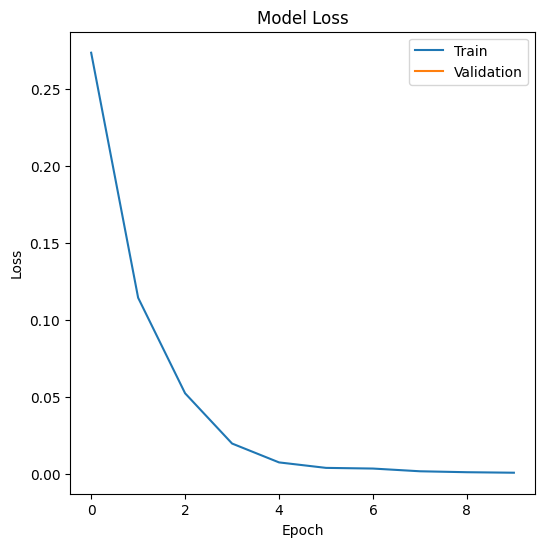

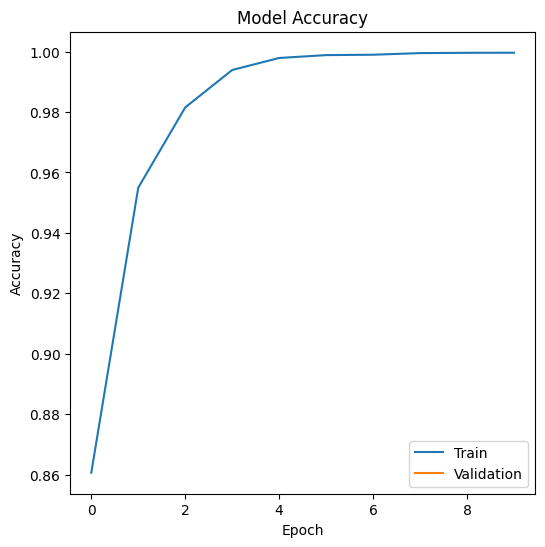

In [15]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


# Test the model

The performance of the model is excellent, with a 99% accuracy rate, which is significantly better than the first NLP implementation I worked on, which achieved a maximum accuracy rate of 88%. <br> 
To confirm the effectiveness of the model, I plan to input a random review and assess the predicted outcome.

In [16]:
# Define encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Define decoder inputs
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs = Input(shape=(None,))
decoder_embedding_output = decoder_embedding(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input sequence to get the encoder states
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character
    target_seq[0, 0] = sentiment_tokenizer.word_index['<Start>']

    # Generate output sequence
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = sentiment_tokenizer.index_word[sampled_token_index]

        # Exit condition: either hit max length or find stop character
        if (sampled_token == '<Stop>' or len(decoded_sentence) > max_sequence_length):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_token

            # Update the target sequence
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            states_value = [h, c]

    return decoded_sentence



In this code, we define a function sequence_to_text that converts a sequence to text. We then generate some translations for the validation data by selecting a random input sequence, using the decode_sequence function to generate the predicted output sequence, and then converting the sequences to text. We print the input, target, and predicted sequences for each example.

In [17]:
def sequence_to_text(sequence, tokenizer):
    text = tokenizer.sequences_to_texts([sequence])[0]
    return text


In [18]:
# Define a new review
new_review = "This movie is fantastic. I loved every minute of it!"

# Convert the review to a sequence of integers
new_review_seq = review_tokenizer.texts_to_sequences([new_review])[0]

# Pad the sequence to the same length as the training data
new_review_seq = pad_sequences([new_review_seq], maxlen=max_sequence_length, padding='post')

# Use the model to predict the sentiment of the review
pred_sentiment_seq = model.predict([new_review_seq, np.zeros((len(new_review_seq), 1))])

# Convert the predicted sentiment sequence to text
pred_sentiment_text = sequence_to_text(np.argmax(pred_sentiment_seq, axis=2)[0], sentiment_tokenizer)

print("Review:", new_review)
print("Predicted sentiment:", pred_sentiment_text)


1/1 [==============================] - 0s 413ms/step
Review: This movie is fantastic. I loved every minute of it!
Predicted sentiment: positive


# Conclusion

The model is performing according to our expectations, as it is able to deliver excellent results despite being trained on a maximum of 100 words per sentence instead of the entire sentence. In fact, the accuracy of the model is an impressive 99%, indicating its high level of proficiency in processing language.